### Part 1: Analyzing Best-Seller Trends Across Product Categories

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats.contingency import association

In [2]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [ ]:
# Create a crosstab
crosstab_result = pd.crosstab(df["category"], df["isBestSeller"]).sort_values(
    by=df.columns[-1], ascending=False
)

# calculate the proportion of best-sellers for each category
proportion_table = round(
    pd.crosstab(df["category"], df["isBestSeller"], normalize="index") * 100, 2
).sort_values(by=crosstab_result.columns[-1], ascending=False)

proportion_table_copy = (
    round(pd.crosstab(df["category"], df["isBestSeller"], normalize="index") * 100, 2)
    .sort_values(by=crosstab_result.columns[-1], ascending=False)
    .head(50)
)
print(proportion_table)

isBestSeller                     False  True 
category                                     
Grocery                          94.19   5.81
Smart Home Security & Lighting   94.23   5.77
Health & Personal Care           94.23   5.77
Mobile Phone Accessories         95.75   4.25
Power & Hand Tools               96.47   3.53
...                                ...    ...
CPUs                            100.00   0.00
CD, Disc & Tape Players         100.00   0.00
Blank Media Cases & Wallets     100.00   0.00
Boxes & Organisers              100.00   0.00
eBook Readers & Accessories     100.00   0.00

[296 rows x 2 columns]


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [19]:
# 1. Chi-Square Properly unpack all four variables from the test
chi2_stat, p_val, dof, expected = chi2_contingency(crosstab_result)

# 2. Print with high precision to see the non-zero decimals
print(f"Standard P-value print: {p_val}")
print(f"Scientific Notation: {p_val:.2e}")
print(f"Manual Calculation P-value: {1 - stats.chi2.cdf(chi2_stat, dof)}")

# 3. Hypothesis Testing
alpha = 0.05
if p_val < alpha:
    print("\nResult: Reject H0")
    print("Meaning: Category and Best-Seller status are STRONGLY linked.")
else:
    print("\nResult: Fail to reject H0")

Standard P-value print: 0.0
Scientific Notation: 0.00e+00
Manual Calculation P-value: 0.0

Result: Reject H0
Meaning: Category and Best-Seller status are STRONGLY linked.


In [ ]:
# compute Cramer's V
CramersV = round(association(crosstab_result, method="cramer"), 2)
print(CramersV)

# Even though there is a statistically significant link between Category and Best-Seller status,
# the effect size is small. This means that while some categories are more likely to have best-sellers than others,
# the category alone isn't the "magic key" to becoming a best-seller. There are likely many other factors (price, reviews, shipping speed) that play a much bigger role.

0.12


3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

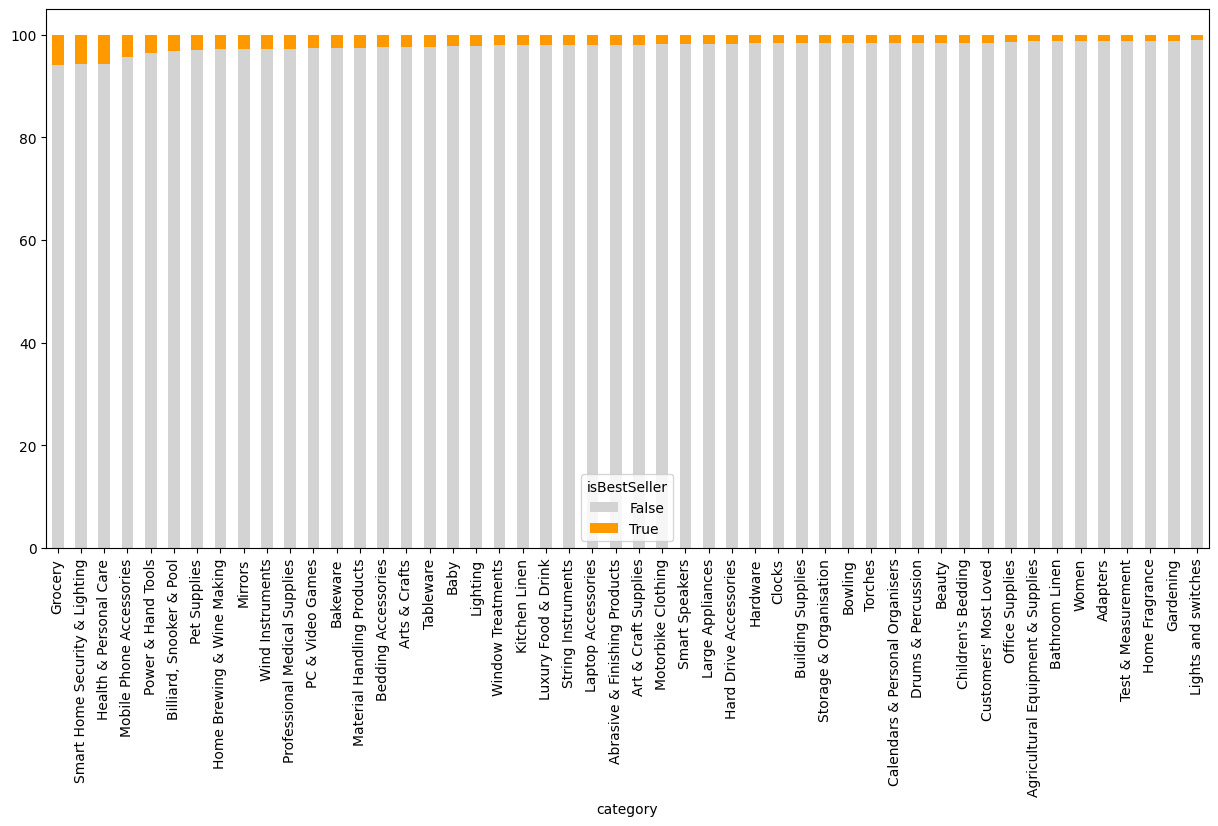

In [ ]:
plt.figure(figsize=(15, 7))
proportion_table_copy.plot(kind="bar", stacked=True, color=["#d3d3d3", "#ff9900"], ax=plt.gca())
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [ ]:
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
lower = Q1 - Q1
upper = round(Q3 + 1.5 * IQR, 2)
print(lower)
print(upper)
df_no_outliers = df[(df["price"] >= lower) & (df["price"] <= upper)]

36.0
0.0
99.99


1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

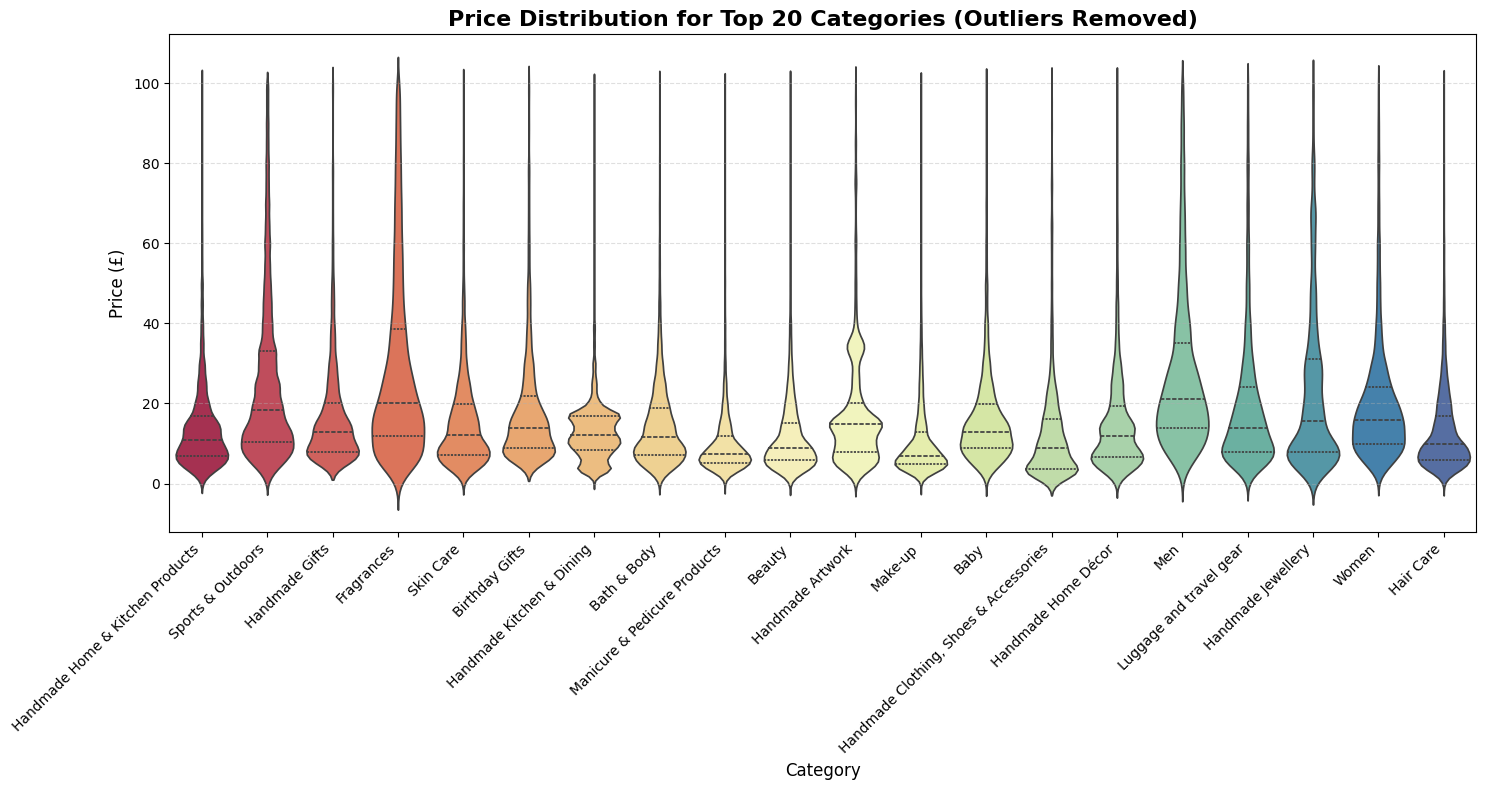

In [ ]:
# 1. Identify the top 20 categories based on count
top_20_cats = df_no_outliers["category"].value_counts().nlargest(20).index

# 2. Filter the dataframe to include only these top 20 categories
df_violin = df_no_outliers[df_no_outliers["category"].isin(top_20_cats)]

# 3. Create the Violin Plot
plt.figure(figsize=(15, 8))
sns.violinplot(
    data=df_violin,
    x="category",
    y="price",
    hue="category",  # Coloring by category
    palette="Spectral",  # Using a distinct color palette
    inner="quartile",  # Shows the Q1, Median, and Q3 inside the violin
    legend=False,
)

# 4. Final Formatting
plt.title(
    "Price Distribution for Top 20 Categories (Outliers Removed)", fontsize=16, fontweight="bold"
)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Price (£)", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate labels to prevent overlapping
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()

# calcualte the median
median_prices = (
    df_no_outliers[df_no_outliers["category"].isin(top_20_cats)]
    .groupby("category")["price"]
    .median()
    .sort_values(ascending=False)  # Sorting makes it easier to read
)
print(median_prices)

# The  Men, Fragrances, Sports & Outdoors tend to have a higher meadian

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

Highest Average Price Category: Motherboards
Average Price: £68.77
Number of products in this category: 74


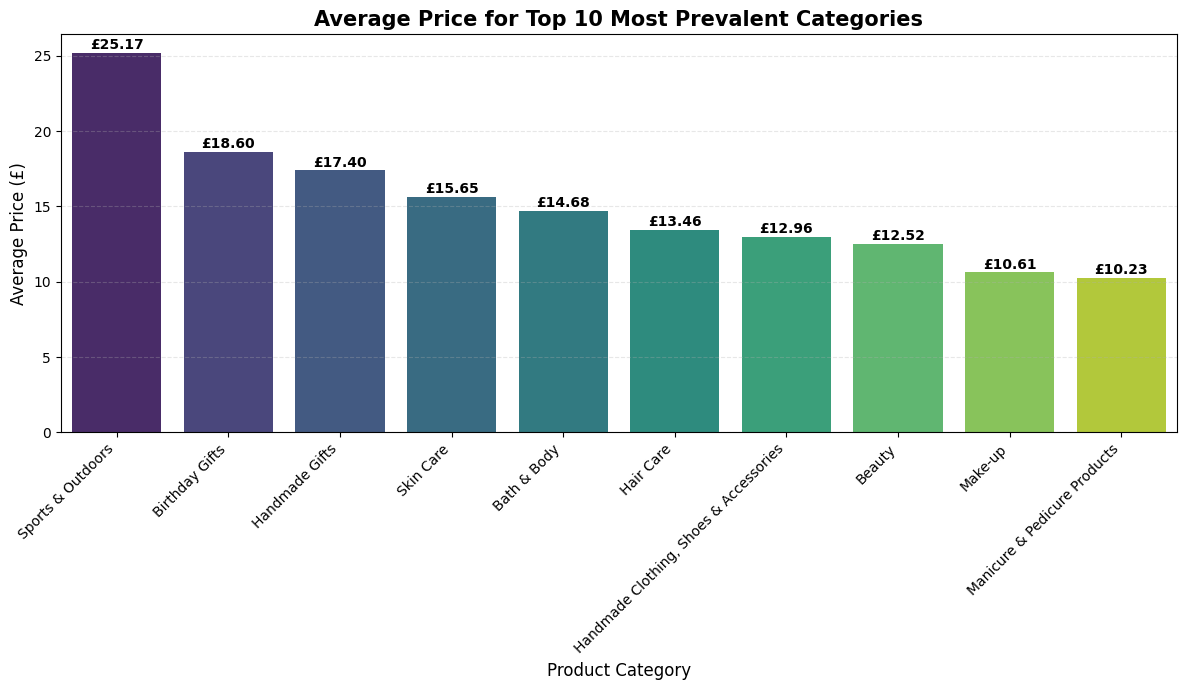

In [ ]:
# 1. Get the top 10 most common categories
top_10_cats_by_count = df_no_outliers["category"].value_counts().nlargest(10).index

# 2. Calculate the average price for these categories
top_10_avg_prices = (
    df_no_outliers[df_no_outliers["category"].isin(top_10_cats_by_count)]
    .groupby("category")["price"]
    .mean()
    .sort_values(ascending=False)
)

# 3. Create the Bar Chart
plt.figure(figsize=(12, 7))
sns.barplot(
    x=top_10_avg_prices.index,
    y=top_10_avg_prices.values,
    palette="viridis",
    hue=top_10_avg_prices.index,
)
plt.legend([], [], frameon=False)  # Hide the redundant legend

# 4. Formatting
plt.title("Average Price for Top 10 Most Prevalent Categories", fontsize=15, fontweight="bold")
plt.xlabel("Product Category", fontsize=12)
plt.ylabel("Average Price (£)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.3)

# Add exact price labels on top of the bars
max_val = top_10_avg_prices.max()
for i, v in enumerate(top_10_avg_prices.values):
    plt.text(i, v + (max_val * 0.01), f"£{v:.2f}", ha="center", fontweight="bold")

plt.tight_layout()


# 1. Group by every category in the dataset and calculate the average price
all_avg_prices = df_no_outliers.groupby("category")["price"].mean()

# 2. Identify the category with the maximum average
highest_avg_cat = all_avg_prices.idxmax()
highest_avg_value = all_avg_prices.max()

# 3. Get the count for that category to see if it's a niche or broad market
highest_cat_count = df_no_outliers[df_no_outliers["category"] == highest_avg_cat].shape[0]

print(f"Highest Average Price Category: {highest_avg_cat}")
print(f"Average Price: £{highest_avg_value:.2f}")
print(f"Number of products in this category: {highest_cat_count}")

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

The category with the highest median rating is: Computer Memory
Median Rating: 4.70
Number of products in this category: 211


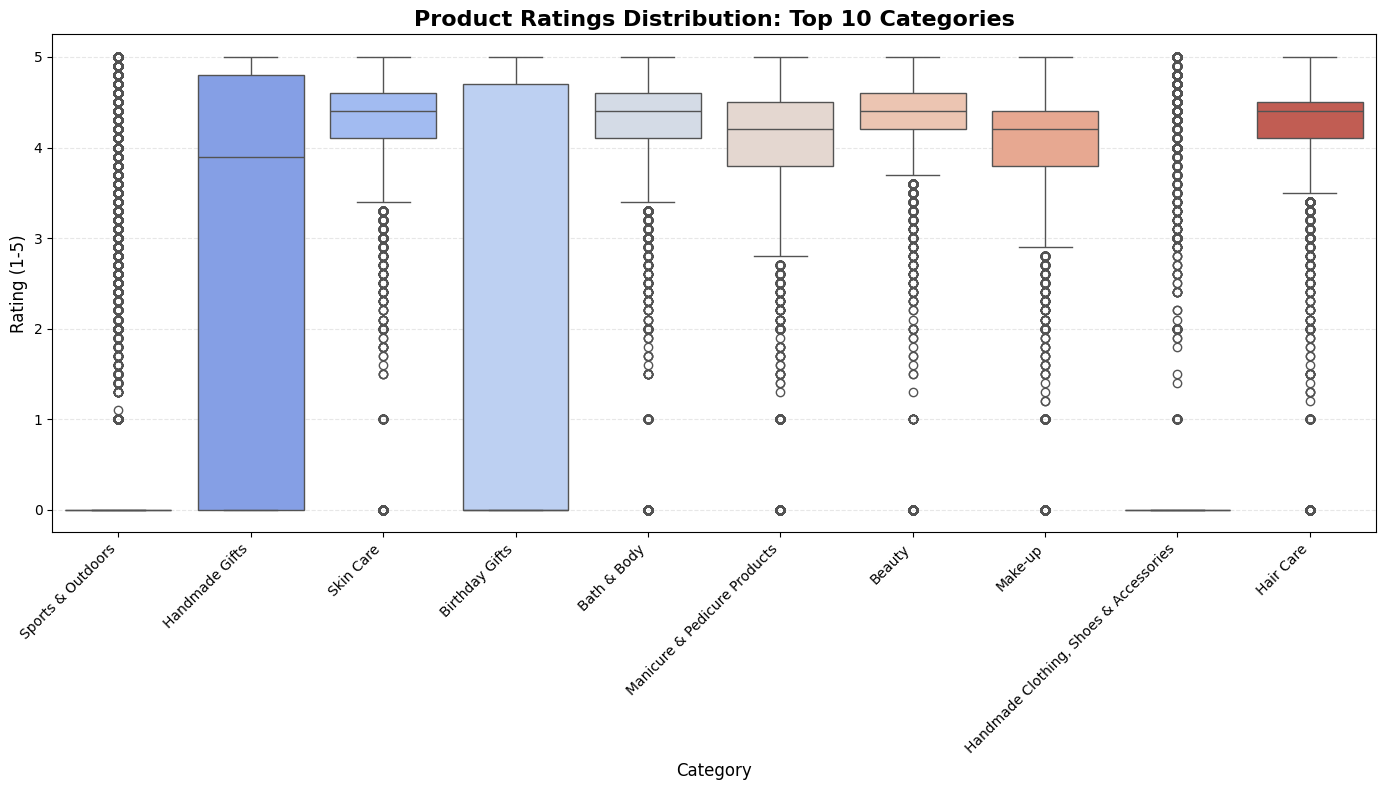

In [ ]:
# 1. Get the top 10 categories by product count
top_10_cats_ratings = df_no_outliers["category"].value_counts().nlargest(10).index

# 2. Filter for these categories
df_top_10_ratings = df_no_outliers[df_no_outliers["category"].isin(top_10_cats_ratings)]

# 3. Create the Side-by-Side Box Plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_top_10_ratings, x="category", y="stars", hue="category", palette="coolwarm")
plt.legend([], [], frameon=False)  # Removes redundant legend

# Formatting
plt.title("Product Ratings Distribution: Top 10 Categories", fontsize=16, fontweight="bold")
plt.xlabel("Category", fontsize=12)
plt.ylabel("Rating (1-5)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig("ratings_distribution_top10.png")


# 1. Calculate median rating for every category in the dataset
all_median_ratings = df_no_outliers.groupby("category")["stars"].median()

# 2. Find the maximum
highest_median_cat = all_median_ratings.idxmax()
highest_median_val = all_median_ratings.max()

# 3. Check the sample size for this leader
count_for_top_cat = df_no_outliers[df_no_outliers["category"] == highest_median_cat].shape[0]

print(f"The category with the highest median rating is: {highest_median_cat}")
print(f"Median Rating: {highest_median_val:.2f}")
print(f"Number of products in this category: {count_for_top_cat}")

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.


1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [ ]:
correlation = df_no_outliers["price"].corr(df_no_outliers["stars"])

print(f"The Correlation Coefficient (r) between Price and Stars is: {correlation:.4f}")
# An r value of -0.0777 indicates a very weak negative correlation between price and ratings.
# Direction: The negative sign suggests that as price increases, there is a very slight tendency for ratings to decrease.

The Correlation Coefficient (r) between Price and Stars is: -0.0777


2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 


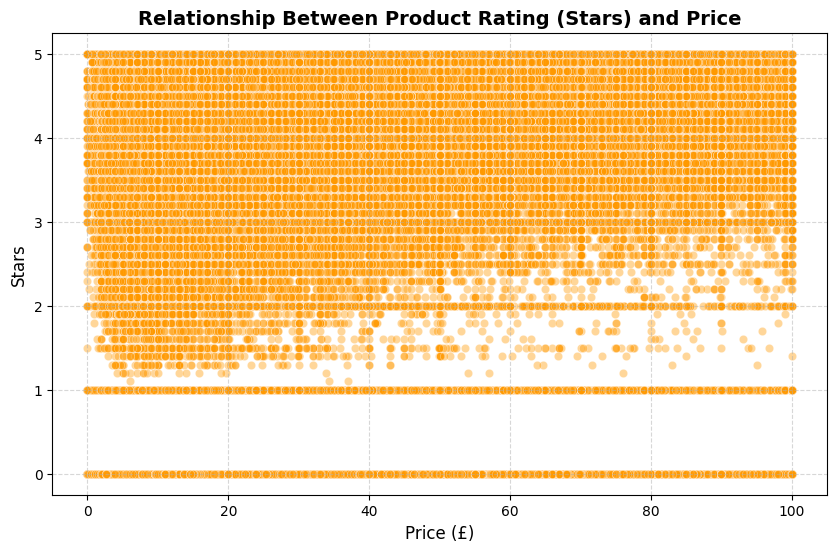

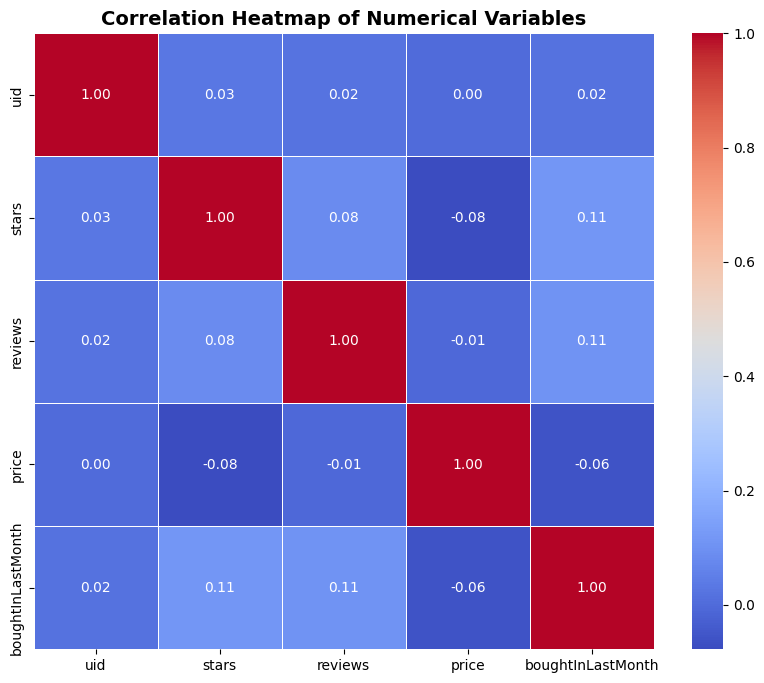

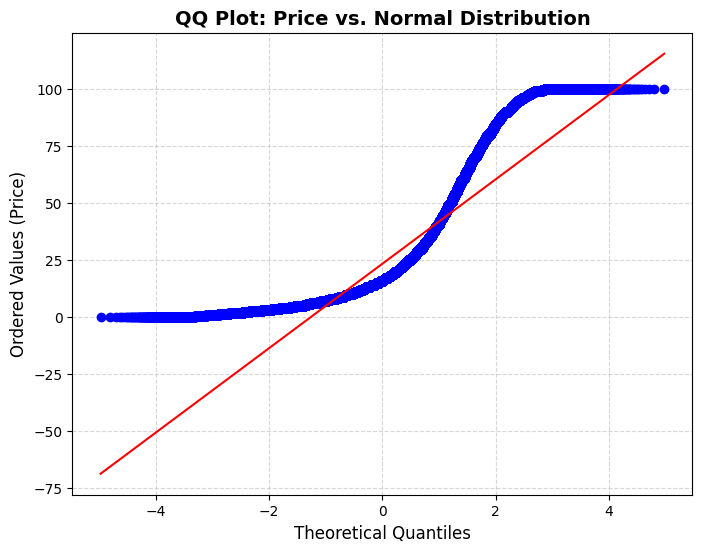

In [ ]:
# 1. Scatter Plot: Price vs. Stars
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_no_outliers, x="price", y="stars", alpha=0.4, color="#ff9900")
plt.title("Relationship Between Product Rating (Stars) and Price", fontsize=14, fontweight="bold")
plt.xlabel("Price (£)", fontsize=12)
plt.ylabel("Stars", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
# We select only the numerical columns for correlation
numeric_cols = df_no_outliers.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=14, fontweight="bold")
plt.show()

# 3. QQ Plot for Price (Normality Check)
plt.figure(figsize=(8, 6))
stats.probplot(df_no_outliers["price"], dist="norm", plot=plt)
plt.title("QQ Plot: Price vs. Normal Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Ordered Values (Price)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()